# Other Analyses

In [1]:
import numpy as np
import pandas as pd
import torch
from scipy import stats
from metvae.model import MetVAE
from metvae.sim import sim_data
from metvae.compute_corr import _compute_vlr

import seaborn as sns
import matplotlib.pyplot as plt

## VLR recovery

### No confounders, no missing

In [2]:
n, d, zero_prop, seed = 100, 50, 0.3, 123
cor_pairs = int(0.2 * d)
mu = list(range(10, 15))

# Simulate data
np.random.seed(seed)
sim = sim_data(n=n, d=d, cor_pairs=cor_pairs, mu=mu)
y = sim['y']
true_cor = sim['cor_matrix']

# Apply log transformation and add biases
log_y = np.log(y)
log_sample_bias = np.log(np.random.uniform(1e-3, 1e-1, size=n))
log_feature_bias = np.log(np.random.uniform(1e-1, 1, size=d))
log_data = log_y + log_sample_bias[:, np.newaxis]  # Adding sample bias
log_data = log_data + log_feature_bias.reshape(1, d)  # Adding feature bias
data = np.exp(log_data)
true_vlr1 = _compute_vlr(data = data)

# Calculate thresholds and apply zeros
thresholds = np.quantile(data, zero_prop, axis=0)
data_miss = np.where(data<thresholds, 0, data)
data_miss = pd.DataFrame(data_miss,
                         columns=data.columns,
                         index=data.index)

In [3]:
torch.manual_seed(123)
np.random.seed(123)

max_epochs=1500
learning_rate=1e-2

model = MetVAE(data=data,
               features_as_rows=False,
               meta=None,
               continuous_covariate_keys=None,
               categorical_covariate_keys=None,
               latent_dim=min(n, d))

model.train(batch_size=100,
            num_workers=0,
            max_epochs=max_epochs,
            learning_rate=learning_rate,
            log_every_n_steps=1)

100%|██████████| 1500/1500 [00:01<00:00, 981.77it/s] 


In [4]:
est_vlr11 = model.cooccurrence().values
corr_coeff11, p_value11 = stats.pearsonr(true_vlr1.ravel(), est_vlr11.ravel())
print('Pearson rho = ', np.round(corr_coeff11, 2), ', p-value = ', np.round(p_value11, 2))

Pearson rho =  0.97 , p-value =  0.0


### No confounders, 30% missing

In [5]:
torch.manual_seed(123)
np.random.seed(123)

max_epochs=1500
learning_rate=1e-2

model = MetVAE(data=data_miss,
               features_as_rows=False,
               meta=None,
               continuous_covariate_keys=None,
               categorical_covariate_keys=None,
               latent_dim=min(n, d))

model.train(batch_size=100,
            num_workers=0,
            max_epochs=max_epochs,
            learning_rate=learning_rate,
            log_every_n_steps=1)

100%|██████████| 1500/1500 [00:03<00:00, 423.56it/s]


In [6]:
est_vlr12 = model.cooccurrence().values
corr_coeff12, p_value12 = stats.pearsonr(true_vlr1.ravel(), est_vlr12.ravel())
print('Pearson rho = ', np.round(corr_coeff12, 2), ', p-value = ', np.round(p_value12, 2))

Pearson rho =  0.82 , p-value =  0.0


### With confounders, no missing

In [7]:
n, d, zero_prop, seed = 100, 50, 0.3, 123
cor_pairs = int(0.2 * d)
mu = list(range(10, 15))
da_prop = 0.1

# Simulate data
np.random.seed(seed)
smd = pd.DataFrame({'x1': np.random.randn(n), 
                    'x2': np.random.choice(['a', 'b'], size=n, replace=True)},
                   index=["s" + str(i) for i in range(n)])

sim = sim_data(n=n, d=d, cor_pairs=cor_pairs, mu=mu, x=smd, cont_list=['x1'], cat_list=['x2'], da_prop=da_prop)
y = sim['y']
x = sim['x']
true_cor = sim['cor_matrix']
beta = sim['beta']

# Apply log transformation and add biases
log_y = np.log(y)
log_sample_bias = np.log(np.random.uniform(1e-3, 1e-1, size=n))
log_feature_bias = np.log(np.random.uniform(1e-1, 1, size=d))
log_data = log_y + log_sample_bias[:, np.newaxis]  # Adding sample bias
log_data = log_data + log_feature_bias.reshape(1, d)  # Adding feature bias
data = np.exp(log_data)

# Compute VLR
log_y_unconfound = log_y - x.values @ beta.T
data_unconfound = np.exp(log_y_unconfound)
true_vlr2 = _compute_vlr(data = data_unconfound)

# Calculate thresholds and apply zeros
thresholds = np.quantile(data, zero_prop, axis=0)
data_miss = np.where(data<thresholds, 0, data)
data_miss = pd.DataFrame(data_miss,
                         columns=data.columns,
                         index=data.index)

In [8]:
torch.manual_seed(123)
np.random.seed(123)

max_epochs=1500
learning_rate=1e-2

model = MetVAE(data=data,
               features_as_rows=False,
               meta=smd,
               continuous_covariate_keys=['x1'],
               categorical_covariate_keys=['x2'],
               latent_dim=min(n, d))

model.train(batch_size=100,
            num_workers=0,
            max_epochs=max_epochs,
            learning_rate=learning_rate,
            log_every_n_steps=1)

100%|██████████| 1500/1500 [00:01<00:00, 919.63it/s]


In [9]:
est_vlr21 = model.cooccurrence().values
corr_coeff21, p_value21 = stats.pearsonr(true_vlr2.ravel(), est_vlr21.ravel())
print('Pearson rho = ', np.round(corr_coeff21, 2), ', p-value = ', np.round(p_value21, 2))

Pearson rho =  0.97 , p-value =  0.0


### With confounders, 30% missing

In [10]:
torch.manual_seed(123)
np.random.seed(123)

max_epochs=1500
learning_rate=1e-2

model = MetVAE(data=data_miss,
               features_as_rows=False,
               meta=smd,
               continuous_covariate_keys=['x1'],
               categorical_covariate_keys=['x2'],
               latent_dim=min(n, d))

model.train(batch_size=100,
            num_workers=0,
            max_epochs=max_epochs,
            learning_rate=learning_rate,
            log_every_n_steps=1)

100%|██████████| 1500/1500 [00:03<00:00, 405.30it/s]


In [11]:
est_vlr22 = model.cooccurrence().values
corr_coeff22, p_value22 = stats.pearsonr(true_vlr2.ravel(), est_vlr22.ravel())
print('Pearson rho = ', np.round(corr_coeff22, 2), ', p-value = ', np.round(p_value22, 2))

Pearson rho =  0.83 , p-value =  0.0


### Visualization

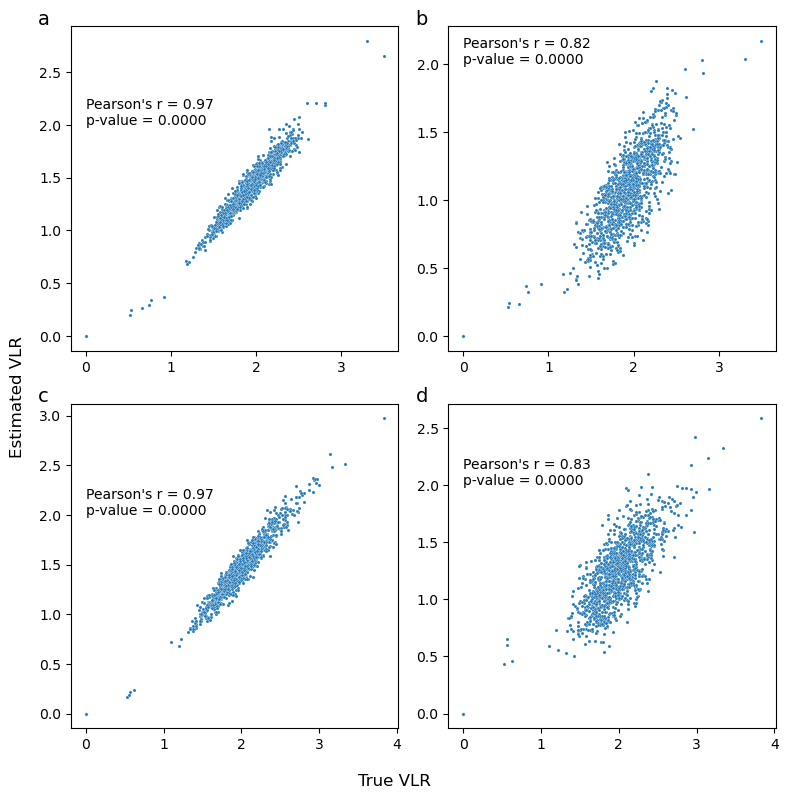

In [12]:
labels = ['a', 'b', 'c', 'd']
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

sns.scatterplot(x=true_vlr1.ravel(), y=est_vlr11.ravel(), s=5, ax=axes[0])
axes[0].text(-0.1, 1.05, labels[0], transform=axes[0].transAxes, fontsize=14, verticalalignment='top')
axes[0].text(0, 2, f"Pearson's r = {corr_coeff11:.2f}\np-value = {p_value11:.4f}")

sns.scatterplot(x=true_vlr1.ravel(), y=est_vlr12.ravel(), s=5, ax=axes[1])
axes[1].text(-0.1, 1.05, labels[1], transform=axes[1].transAxes, fontsize=14, verticalalignment='top')
axes[1].text(0, 2, f"Pearson's r = {corr_coeff12:.2f}\np-value = {p_value12:.4f}")

sns.scatterplot(x=true_vlr2.ravel(), y=est_vlr21.ravel(), s=5, ax=axes[2])
axes[2].text(-0.1, 1.05, labels[2], transform=axes[2].transAxes, fontsize=14, verticalalignment='top')
axes[2].text(0, 2, f"Pearson's r = {corr_coeff21:.2f}\np-value = {p_value21:.4f}")

sns.scatterplot(x=true_vlr2.ravel(), y=est_vlr22.ravel(), s=5, ax=axes[3])
axes[3].text(-0.1, 1.05, labels[3], transform=axes[3].transAxes, fontsize=14, verticalalignment='top')
axes[3].text(0, 2, f"Pearson's r = {corr_coeff22:.2f}\np-value = {p_value22:.4f}")

fig.supxlabel('True VLR')
fig.supylabel('Estimated VLR')

plt.tight_layout() 
plt.savefig('../results/figures/supp_vae_recover_vlr.pdf', bbox_inches='tight')
plt.show()

## Transfer learning

In [13]:
n, d, zero_prop, seed = 200, 200, 0.3, 123
cor_pairs = int(0.2 * d)
mu = list(range(10, 15))
da_prop = 0.1
n_sub = int(n/2)

# Simulate data
np.random.seed(seed)
smd = pd.DataFrame({'x1': np.random.randn(n), 
                    'x2': np.random.choice(['a', 'b'], size=n, replace=True)},
                   index=["s" + str(i) for i in range(n)])

sim = sim_data(n=n, d=d, cor_pairs=cor_pairs, mu=mu, x=smd, cont_list=['x1'], cat_list=['x2'], da_prop=da_prop)
y = sim['y']
x = sim['x']
beta = sim['beta']
true_cor = sim['cor_matrix']

# Apply log transformation and add biases
log_y = np.log(y)
log_sample_bias = np.log(np.random.uniform(1e-3, 1e-1, size=n))
log_feature_bias = np.log(np.random.uniform(1e-1, 1, size=d))
log_data = log_y + log_sample_bias[:, np.newaxis]  # Adding sample bias
log_data = log_data + log_feature_bias.reshape(1, d)  # Adding feature bias
data = np.exp(log_data)

# Calculate thresholds and apply zeros
thresholds = np.quantile(data, zero_prop, axis=0)
data_miss = np.where(data<thresholds, 0, data)
data_miss = pd.DataFrame(data_miss,
                         columns=data.columns,
                         index=data.index)

# A reduced dataset
smd_sub = smd.iloc[range(n_sub), :]
data_sub = data_miss.iloc[range(n_sub), :]

### Run the MetVAE model

In [14]:
torch.manual_seed(123)
np.random.seed(123)

max_epochs=1000
learning_rate=1e-2

model = MetVAE(data=data_miss,
               features_as_rows=False,
               meta=smd,
               continuous_covariate_keys=['x1'],
               categorical_covariate_keys=['x2'],
               latent_dim=min(n_sub, d),
               use_gpu=False,
               logging=False)

model.train(batch_size=100,
            num_workers=0,
            max_epochs=max_epochs,
            learning_rate=learning_rate,
            log_every_n_steps=1)

100%|██████████| 1000/1000 [00:14<00:00, 67.66it/s]


In [15]:
model.get_corr(num_sim=1000)
results_metvae = model.sparse_by_filter(p_adj_method='fdr_bh', cutoff=0.05)
est_cor = results_metvae['sparse_estimate']

# Calculate summary statistics
true_idx = true_cor[np.tril_indices_from(true_cor, k=-1)] != 0
est_idx = est_cor[np.tril_indices_from(est_cor, k=-1)] != 0
tpr = np.sum(est_idx & true_idx) / np.sum(true_idx)
fpr = np.sum(est_idx & ~true_idx) / np.sum(~true_idx)
fdr = np.sum(est_idx & ~true_idx) / np.sum(est_idx)
print('tpr = ', tpr, ', fpr = ', fpr, ', fdr = ', fdr)

tpr =  0.95 , fpr =  0.0004028197381671702 , fdr =  0.17391304347826086


### Save trained weights

In [16]:
torch.save(model.model.state_dict(), '../results/intermediate_results/others/pretrain.pth')

### Train the reduced dataset using pre-trained weights

In [17]:
torch.manual_seed(123)
np.random.seed(123)

# Load the model state
model1 = MetVAE(data=data_sub,
                features_as_rows=False,
                meta=smd_sub,
                continuous_covariate_keys=['x1'],
                categorical_covariate_keys=['x2'],
                latent_dim=min(n_sub, d),
                use_gpu=False,
                logging=False)
model1.model.load_state_dict(torch.load('../results/intermediate_results/others/pretrain.pth'))
model1.model.eval() 

/var/folders/rn/10vtwtd944j73gfdxc_pbl680000gr/T/ipykernel_23155/2986337510.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.model.load_state_dict(torch.load('../

VAE(
  (encnorm): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encode_mu): Linear(in_features=200, out_features=100, bias=True)
  (encode_logvar): Linear(in_features=200, out_features=100, bias=True)
  (decode_mu): Linear(in_features=100, out_features=200, bias=True)
)

In [18]:
max_epochs=100
learning_rate=1e-3

model1.train(batch_size=100,
             num_workers=0,
             max_epochs=max_epochs,
             learning_rate=learning_rate,
             log_every_n_steps=1)

100%|██████████| 100/100 [00:00<00:00, 146.48it/s]


<Axes: xlabel='Epoch', ylabel='Training Loss'>

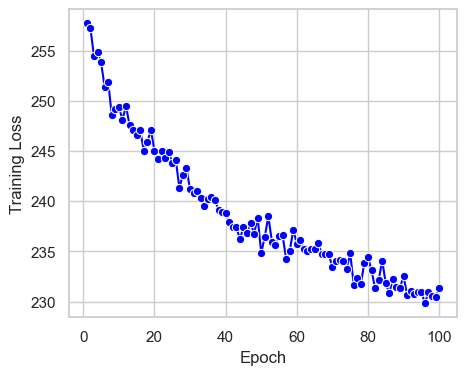

In [19]:
df_loss = pd.DataFrame({
    'Epoch': range(1, max_epochs+1),
    'Training Loss': model1.train_loss
})

plt.figure(figsize=(5, 4))
sns.set_theme(style="whitegrid")   
sns.lineplot(data=df_loss, x='Epoch', y='Training Loss', marker='o', color='blue')

In [20]:
model1.get_corr(num_sim=1000)
results1 = model1.sparse_by_filter(p_adj_method='fdr_bh', cutoff=0.05)
est_cor1 = results1['sparse_estimate']

# Calculate summary statistics
true_idx = true_cor[np.tril_indices_from(true_cor, k=-1)] != 0
est_idx = est_cor1[np.tril_indices_from(est_cor1, k=-1)] != 0
tpr = np.sum(est_idx & true_idx) / np.sum(true_idx)
fpr = np.sum(est_idx & ~true_idx) / np.sum(~true_idx)
fdr = np.sum(est_idx & ~true_idx) / np.sum(est_idx)
print('tpr = ', tpr, ', fpr = ', fpr, ', fdr = ', fdr)

tpr =  0.775 , fpr =  5.0352467270896274e-05 , fdr =  0.03125


### Train the reduced dataset from scratch

In [21]:
# Run the MetVAE model
torch.manual_seed(123)
np.random.seed(123)

# Load the model state
model2 = MetVAE(data=data_sub,
                features_as_rows=False,
                meta=smd_sub,
                continuous_covariate_keys=['x1'],
                categorical_covariate_keys=['x2'],
                latent_dim=min(n, d),
                use_gpu=False,
                logging=False)

max_epochs=100
learning_rate=1e-3

model2.train(batch_size=100,
             num_workers=0,
             max_epochs=max_epochs,
             learning_rate=learning_rate,
             log_every_n_steps=1)

100%|██████████| 100/100 [00:00<00:00, 134.17it/s]


<Axes: xlabel='Epoch', ylabel='Training Loss'>

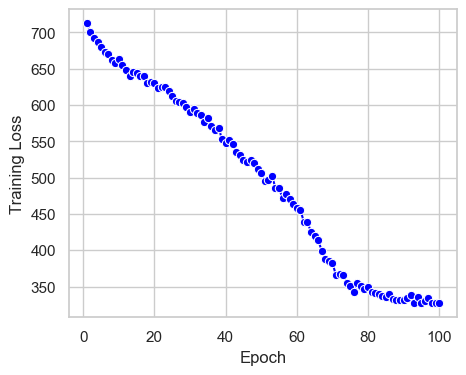

In [22]:
df_loss = pd.DataFrame({
    'Epoch': range(1, max_epochs+1),
    'Training Loss': model2.train_loss
})

plt.figure(figsize=(5, 4))
sns.set_theme(style="whitegrid")   
sns.lineplot(data=df_loss, x='Epoch', y='Training Loss', marker='o', color='blue')

In [23]:
model2.get_corr(num_sim=1000)
results2 = model2.sparse_by_filter(p_adj_method='fdr_bh', cutoff=0.05)
est_cor2 = results2['sparse_estimate']

# Calculate summary statistics
true_idx = true_cor[np.tril_indices_from(true_cor, k=-1)] != 0
est_idx = est_cor2[np.tril_indices_from(est_cor2, k=-1)] != 0
tpr = np.sum(est_idx & true_idx) / np.sum(true_idx)
fpr = np.sum(est_idx & ~true_idx) / np.sum(~true_idx)
fdr = np.sum(est_idx & ~true_idx) / np.sum(est_idx)
print('tpr = ', tpr, ', fpr = ', fpr, ', fdr = ', fdr)

tpr =  0.575 , fpr =  5.0352467270896274e-05 , fdr =  0.041666666666666664
